In [1]:
# Initialize Otter
import otter
grader = otter.Notebook("covid_part2.ipynb")

# Final Project: COVID-19 Dataset
## Exploring COVID-19 Data through Modeling
## Due Date: Thursday, December 13th, 11:59 PM
## Collaboration Policy

Data science is a collaborative activity. While you may talk with other groups about
the project, we ask that you **write your solutions individually**. If you do
discuss the assignments with others outside of your group please **include their names** at the top
of your notebook.


## This Assignment

In this final project, we will investigate COVID-19 data over the past year. This data contains information about COVID-19 case counts, mortalities, vaccination rates, and various other metadata that can assist in modeling various aspects of COVID-19.

Through this final project, you will demonstrate your experience with:
* Data cleaning and EDA using Pandas
* Unsupervised and supervised learning techniques
* Visualization


## Goal

Model and analyze the temporal evolution of COVID-19 mortalities or cases using one unsupervised and one supervised technique of your choice. Interpret your models' results through visualizations, and draw insightful conclusions about the modeling of COVID-19 data.

Recall that we studied linear and logistic regression, decision trees, random forests as part of supervised learning (with labels) and clustering, PCA as part of unsupervised learning (without labels). You are free to use any methods that you find suitable to answer the problem at hand.

In [2]:
# Run this cell to set up your notebook
import numpy as np
from geopy import *
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.cluster import *
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
from scipy.stats import pearsonr
import re

cases = pd.read_csv('data/time_series_covid19_confirmed_US.csv') # https://github.com/CSSEGISandData/COVID-19/blob/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_US.csv
vaccinations = pd.read_csv('data/people_vaccinated_us_timeline.csv') # https://raw.githubusercontent.com/govex/COVID-19/master/data_tables/vaccine_data/us_data/time_series/people_vaccinated_us_timeline.csv
counties = pd.read_csv('data/co-est2020.csv', encoding='latin-1') # https://www2.census.gov/programs-surveys/popest/datasets/2010-2020/counties/totals/co-est2020.csv
mask_use = pd.read_csv('data/mask-use-by-county.csv') # https://github.com/nytimes/covid-19-data/blob/master/mask-use/mask-use-by-county.csv

<br/><br/><br/>

---

<br/><br/><br/>

## Data Cleaning (Again!)

For this section, please copy over the appropriate answers from your previous notebook submission.

### Part 1: Question 1a

Impute the null values in *all* the datasets with zero values or empty strings where appropriate.

<!--
BEGIN QUESTION
name: q1a
points: 0
-->

In [3]:
cases = cases.fillna(0)
vaccinations = vaccinations.fillna(0)
counties = counties.fillna(0)
mask_use = mask_use.fillna(0)

In [4]:
grader.check("q1a")

q1a results: All test cases passed!

### Part 1: Question 1d

Generate a valid FIPS code for the `counties` table.

*Hint*: Refer to [this](https://transition.fcc.gov/oet/info/maps/census/fips/fips.txt) guide on FIPS codes.

<!--
BEGIN QUESTION
name: q1d
points: 0
-->

In [5]:
counties['FIPS'] = (1000 * counties['STATE']) + counties['COUNTY']
counties.head()

,SUMLEV,REGION,DIVISION,STATE,COUNTY,STNAME,CTYNAME,CENSUS2010POP,ESTIMATESBASE2010,POPESTIMATE2010,...,POPESTIMATE2013,POPESTIMATE2014,POPESTIMATE2015,POPESTIMATE2016,POPESTIMATE2017,POPESTIMATE2018,POPESTIMATE2019,POPESTIMATE042020,POPESTIMATE2020,FIPS
0,40,3,6,1,0,Alabama,Alabama,4779736,4780118,4785514,...,4831586,4843737,4854803,4866824,4877989,4891628,4907965,4920706,4921532,1000
1,50,3,6,1,1,Alabama,Autauga County,54571,54582,54761,...,54747,54922,54903,55302,55448,55533,55769,56130,56145,1001
2,50,3,6,1,3,Alabama,Baldwin County,182265,182263,183121,...,194978,199306,203101,207787,212737,218071,223565,227989,229287,1003
3,50,3,6,1,5,Alabama,Barbour County,27457,27454,27325,...,26946,26768,26300,25828,25169,24887,24657,24652,24589,1005
4,50,3,6,1,7,Alabama,Bibb County,22915,22904,22858,...,22510,22541,22553,22590,22532,22300,22313,22199,22136,1007


In [6]:
grader.check("q1d")

q1d results: All test cases passed!

### Part 1: Question 1e

Merge the `counties`, `cases`, and `mask_use` tables on an appropriate primary key to generate county-wise data.

<!--
BEGIN QUESTION
name: q1e
points: 0
-->

In [7]:
first_merge = counties.merge(cases, how = 'inner', on = 'FIPS')
county_data = first_merge.merge(mask_use, how = 'inner', left_on = 'FIPS', right_on = 'COUNTYFP')
county_data

,SUMLEV,REGION,DIVISION,STATE,COUNTY,STNAME,CTYNAME,CENSUS2010POP,ESTIMATESBASE2010,POPESTIMATE2010,...,9/9/21,9/10/21,9/11/21,9/12/21,COUNTYFP,NEVER,RARELY,SOMETIMES,FREQUENTLY,ALWAYS
0,50,3,6,1,1,Alabama,Autauga County,54571,54582,54761,...,9145,9207,9246,9287,1001,0.053,0.074,0.134,0.295,0.444
1,50,3,6,1,3,Alabama,Baldwin County,182265,182263,183121,...,34536,34726,34872,34950,1003,0.083,0.059,0.098,0.323,0.436
2,50,3,6,1,5,Alabama,Barbour County,27457,27454,27325,...,3243,3260,3282,3295,1005,0.067,0.121,0.120,0.201,0.491
3,50,3,6,1,7,Alabama,Bibb County,22915,22904,22858,...,3727,3752,3778,3795,1007,0.020,0.034,0.096,0.278,0.572
4,50,3,6,1,9,Alabama,Blount County,57322,57322,57372,...,9048,9095,9161,9176,1009,0.053,0.114,0.180,0.194,0.459
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3136,50,4,8,56,37,Wyoming,Sweetwater County,43806,43806,43580,...,6034,6111,6111,6111,56037,0.061,0.295,0.230,0.146,0.268
3137,50,4,8,56,39,Wyoming,Teton County,21294,21298,21298,...,4587,4611,4611,4611,56039,0.095,0.157,0.160,0.247,0.340
3138,50,4,8,56,41,Wyoming,Uinta County,21118,21121,21090,...,3168,3204,3204,3204,56041,0.098,0.278,0.154,0.207,0.264
3139,50,4,8,56,43,Wyoming,Washakie County,8533,8528,8531,...,1111,1120,1120,1120,56043,0.204,0.155,0.069,0.285,0.287


In [8]:
grader.check("q1e")

q1e results: All test cases passed!

<br/><br/><br/>

---

<br/><br/><br/>

## Question 5: Guided Supervised Modeling

This section will guide you through creating a supervised learning framework that will predict the number of COVID-19 cases per capita given various COVID-19 safety protocols that have been implemented. Then, we will investigate the bias, variance, and observational noise of this framework.

Note that any answer responses without the appropriate work (i.e. code or math) will be subject to additional review and will not receive any credit.

<!-- BEGIN QUESTION -->

### Question 5a

We will use county-wise mask usage data to predict the number of COVID-19 cases on September 12th, 2021. Create a visualization that shows the pairwise correlation between each combination of column in the mask usage data and the number of COVID-19 cases.

*Hint*: You should be plotting 36 correlations.
<!--
BEGIN QUESTION
name: q5a
points: 3
manual: True
-->

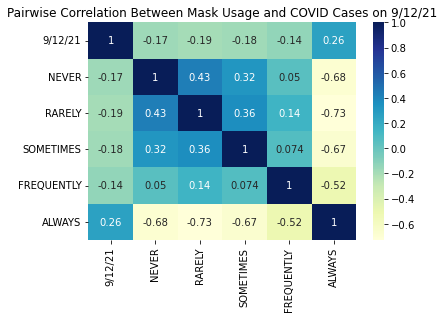

In [9]:
relevant_cols = county_data[['9/12/21', 'NEVER', 'RARELY', 'SOMETIMES', 'FREQUENTLY', 'ALWAYS']]
sns.heatmap(relevant_cols.corr(), cmap="YlGnBu", annot=True)
plt.title('Pairwise Correlation Between Mask Usage and COVID Cases on 9/12/21');

<!-- END QUESTION -->

### Question 5b

Train a linear regression model to predict the number of COVID-19 cases using county-wise mask usage data for September 12, 2021. Evaluate your model's RMSE on a held-out validation set with 33% of the county-wise data. When possible, make sure to set `random_state = 42` when splitting your data into training and test sets.
<!--
BEGIN QUESTION
name: q5b
points: 5
-->

In [10]:
def rmse(predicted, actual):
    return np.sqrt(np.mean((actual - predicted) **2))

In [11]:
X_q5b = county_data[['NEVER', 'RARELY', 'SOMETIMES', 'FREQUENTLY', 'ALWAYS']]
y_q5b = county_data['9/12/21']

# Make sure to set random_state = 42 and test_size = 0.33!
X_q5b_train, X_q5b_test, y_q5b_train, y_q5b_test = train_test_split(X_q5b, y_q5b, random_state=42, test_size=0.33)

linear_model = LinearRegression()
linear_model.fit(X_q5b_train, y_q5b_train)

train_predictions = linear_model.predict(X_q5b_train)
test_predictions = linear_model.predict(X_q5b_test)

train_rmse_cases = rmse(train_predictions, y_q5b_train)
test_rmse_cases = rmse(test_predictions, y_q5b_test)

train_rmse_cases, test_rmse_cases

(27834.430707426982, 62591.13087482178)

In [12]:
grader.check("q5b")

q5b results: All test cases passed!

<!-- BEGIN QUESTION -->

### Question 5c

Explain potential reasons the test set RMSE is much higher as compared to the training set RMSE.
<!--
BEGIN QUESTION
name: q5c
points: 3
manual: True
-->

The test RMSE could be much higher as compared to the training set RMSE due to overfitting. Since we are building the model using the training data, the model could be fit too closely to the training set, resulting in a relatively low RMSE for the training set but a high RMSE for the test set. This means that the model is bad at generalizing to new data and is fit too closely to the data that it was trained on. This could be because we selected too many features for our model. It could also be because our model has too much complexity. 

<!-- END QUESTION -->

### Question 5d

Instead of predicting the number of COVID-19 cases, redo part (b) by predicting the number of cases per capita. Report the model's RMSE on the training and validation set.

Comment on the relationship between the training and test RMSE by predicting the number of cases per capita instead of the total number of cases.
<!--
BEGIN QUESTION
name: q5d
points: 3
-->

In [13]:
county_data['Cases Per Capita'] = county_data['9/12/21'] / county_data['POPESTIMATE2020']
X_q5d = county_data[['NEVER', 'RARELY', 'SOMETIMES', 'FREQUENTLY', 'ALWAYS']]
y_q5d = county_data['Cases Per Capita']
X_q5d_train, X_q5d_test, y_q5d_train, y_q5d_test = train_test_split(X_q5d, y_q5d, random_state=42, test_size=0.33)

per_capita_model = LinearRegression()
per_capita_model.fit(X_q5d_train, y_q5d_train)

train_predictions_pc = per_capita_model.predict(X_q5d_train)
test_predictions_pc = per_capita_model.predict(X_q5d_test)

train_rmse_cpc = rmse(train_predictions_pc, y_q5d_train)
test_rmse_cpc = rmse(test_predictions_pc, y_q5d_test)

train_rmse_cpc, test_rmse_cpc

(0.03540985737823185, 0.038167903498916037)

In [14]:
grader.check("q5d")

q5d results: All test cases passed!

The difference between the training and test RMSE is much less when we predict the number of cases per capita instead of the total number of cases. The test RMSE is only around 1.08 times higher than the training RSME when we predict the number of cases per capita, but when we predict the total number of cases the test RMSE is around 2.25 times higher than the training RMSE. This could be due to the fact that the number of cases per capita has less noise than the total number of cases, which leads to less overfitting.

<!-- BEGIN QUESTION -->

### Question 5e

Visualize the model outputs from part (d) by plotting the predictions $\hat{y}$ versus the observations $y$. Comment on what the plot indicates about our linear model as a comment in the code cell.

<!--
BEGIN QUESTION
name: q5e
points: 3
manual: True
-->

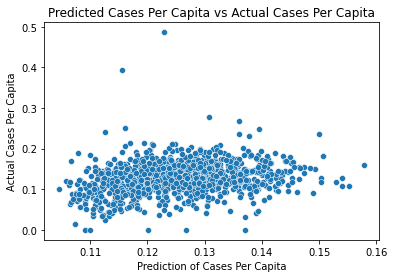

In [15]:
sns.scatterplot(x=test_predictions_pc, y=y_q5d_test);
plt.xlabel('Prediction of Cases Per Capita')
plt.ylabel('Actual Cases Per Capita')
plt.title('Predicted Cases Per Capita vs Actual Cases Per Capita');
# The plot shows that the model is somewhat good in that the predictions lie between 0.10 and 0.16, and this is where the 
# majority of the actual cases per capita lie. However, the model is bad at predicting cases per capita outside of this range.
# Also, there seems to be a fairly low correlation between predicted cases and actual cases per capita, which means that the 
# model is not too accurate.

<!-- END QUESTION -->

### Question 5f

We will investigate the bias and variance of this improved model on the test set using the bias-variance decomposition to formalize the behaviour of our model. To generate an empirical estimate of the errors and the parameters in the bias-variance decomposition, train 1000 bootstrapped models on the training dataset from part (d).

<!--
BEGIN QUESTION
name: q5f
points: 5
-->

In [16]:
models = []
train_df = county_data[['NEVER', 'RARELY', 'SOMETIMES', 'FREQUENTLY', 'ALWAYS', 'Cases Per Capita']]

for i in range(1000):
    sample = train_df.sample(frac=1, replace=True)
    X_vals = sample[['NEVER', 'RARELY', 'SOMETIMES', 'FREQUENTLY', 'ALWAYS']]
    y_vals = sample['Cases Per Capita']
    X_q5f_train, X_q5f_test, y_q5f_train, y_q5f_test = train_test_split(X_vals, y_vals, random_state=42, test_size=0.33)
    model = LinearRegression()
    model.fit(X_q5f_train, y_q5f_train)
    models.append(model)

In [17]:
grader.check("q5f")

q5f results: All test cases passed!

### Question 5g

To investigate the variance in our test predictions, we sample a particular test point $(x_i, y_i)$ such that $i = 100$. In other words, we will use the 100th point in the test set from part (d), `(X_q5d_test.iloc[100], y_q5d_test.iloc[100])` as the testing point.

Generate predictions and square errors for this test point for all 1000 models, and calculate the *proportion* of the *expected* square error that is captured by the model prediction variance. In other words, we wish to estimate the following quantity:

$$
\frac{\mathrm{Var}(f_\theta(x_i))}{\mathrm{E}_\theta[(y_i - f_\theta(x_i))^2]}
$$

*Hint*: Refer to the bias-variance decomposition from lecture.
<!--
BEGIN QUESTION
name: q5g
points: 5
-->

In [18]:
predictions = []
for model in models:
    pred = model.predict(np.array(X_q5d_test.iloc[100]).reshape(1, -1))
    predictions.append(pred)

predictions = np.array(predictions)
variance = np.var(predictions)
expected_val = np.mean((y_q5d_test.iloc[100] - predictions)**2)
prop_var = variance / expected_val
prop_var

0.0014757131071340514

In [19]:
grader.check("q5g")

q5g results: All test cases passed!

<!-- BEGIN QUESTION -->

### Question 5h

Using the bias-variance decomposition, comment on how much the variance of the model contributes to the error on the sample point above. We will extend this scenario to analyze the noise term in the bias-variance decomposition, specifically with regards to this COVID-19 dataset. Consider the following:

i) Assuming no observational noise (i.e. $\epsilon = 0$), what is the *magnitude* of the empirical model bias on this sample point?

ii) Clearly, there is a non-trivial amount of observational noise with COVID-19 case data simply due to how testing works and occurs. Please take a look at [this article](https://fivethirtyeight.com/features/coronavirus-case-counts-are-meaningless/) for more information. Given this infomation, explain the issues with the assumptions and result in 5h(i).

iii) Recall that we typically assume $y = g(x) + \epsilon$, where $\epsilon \sim \mathcal{N}(\mu, \sigma)$. In the theoretical setting for bias-variance, we have assumed $\mu = 0, \sigma > 0$. In this practical setting, analyze and determine how $\epsilon$ could be modeled (as a normal distribution, but you may also consider how it could be modeled as another distribution). Are there any immediate issues with the assumptions we have made in the theoretical setting where $\mu = 0, \sigma > 0$? What conditions on $\mu, \sigma$ could be more appropriate and why?

iv) Does the standard bias-variance decomposition presented in lecture hold given $\epsilon$ being normally distributed according to your answer in part (iii)? If so, please explain why. If not, explain why it does not hold and if possible, how to modify the bias-variance decomposition to make it hold (i.e. perhaps there is an additional noise term $E[\epsilon^3]$). 

*Hint*: Try to express $y = g(x) + \epsilon$ by adding and subtracting a certain quantity.

v) Intuitively, is it possible to minimize the true model bias to 0 given your $\epsilon$ formulation in part (iii)? Why or why not? Justify your answer using part (iv) if possible.

vi) Consider the infinite sample case where an oracle grants you as many samples as requested, and answer the same question in part (v). Is it possible to minimize the true model bias to 0 given your $\epsilon$ formulation in part (iii)? Conclude with an analysis of what our modeling task can approximate using $X\theta \approx y$ in the finite and infinite sample case.

<!--
BEGIN QUESTION
name: q5h
points: 24
manual: True
-->

i) Assuming no observational noise, the magnitude of the empirical model bias on this sample point would be about 0.04. 

ii) The overarching issue with the assumptions and result in 5h(i) is how reported case counts for COVID-19 are lower than the actual number of infections, proving the existence of a nontrivial amount of observational noise in testing for COVID-19 cases. The author of this article explains a variety of ways in which COVID-19 testing is lowered by outside factors. Specifically, he addresses how "there’s a long lag between when someone is infected, when they develop symptoms, when they get tested and when those test results are reported", reinforcing the idea that these tests are inconsistent. Additionally, he discusses the high prevalence of incorrect results in testing, like false positives and false negatives. Furthermore, he talks about how different approaches to testing, like a robust growth in testing or a sudden, one-time increase in testing, or a high test floor with a a low test ceiling, can in fact serve as interventions that impact the results we get from COVID-19 testing. Cases will always be under reported because the false negative rate is much higher than the false positive rate, so it is very unlikely that test cases will ever be over-reported.

iii) In our practical setting, some of the assumptions that we make in the theoretical setting would no longer hold. When we assume $\mu = 0$, this is because we assume that our observational noise is 0. However, in a real world setting, our noise's mean is most likely not 0, and probably negative. This is because testing is very inconsistent and there is a high false negative rate, so cases are realistically under reported by county, so the noise is actually a negative value. This would lead to our $\mu < 0$. Our assumption for standard deviation holds because in definition it is always positive (squared value of variance).

iv) If the noise is normally distributed according to my answer in iii), our equation for bias-variance decomposition needs a slight adjustment. When we decompose bias-variance, we assume that the E(y), where $y = g(x) + \epsilon$, is $g(x)$, and this is because we assume E($\epsilon$) is 0. In reality, as explained above, E($\epsilon$) is actually negative because the mean is negative, so every place where E(y) is calculated in the bias-variance decompostion must be altered from $g(x)$ to $g(x) +$ E($\epsilon$). 

v) No, it would be impossible to reduce the model bias to 0 under the new assumptions presented in iii). Now that E($\epsilon$) is non-negative, the true values of g(x) will never be exactly equal to the predicted values of y because of this non-negative amount of noise that will never cancel out (mean will never be 0).

vi) No, it is still impossible. Along with the intuition in part v), mathematically model bias is calculated as $\mathbb{E}(\hat{Y}(x) - Y) ~ = ~ \mathbb{E}(\hat{Y}(x)) - \mathbb{E}(Y) ~ = ~ \mathbb{E}(\hat{Y}(x)) - g(x)$. However, when the E($\epsilon$) is no longer equivalent to 0, and the bias variance decomposition is modified as in iv), then the E(Y) in the step 2 of the equation becomes something different in step 3. Now, model bias would be $\mathbb{E}(\hat{Y}(x) - Y) ~ = ~ \mathbb{E}(\hat{Y}(x)) - \mathbb{E}(Y) ~ = ~ \mathbb{E}(\hat{Y}(x)) - (g(x) + \mathbb{E}(\epsilon))$. With the intution laid out in part v) even unlimited amount of samples will never reduce the model bias to 0.



<!-- END QUESTION -->

### Question 5i

Using the bias-variance decomposition for each test point, calculate the average variance and average test mean-square error across the entire test set from part (d). In other words, estimate the following quantities:

$$
\frac{1}{n} \sum_i \mathrm{Var}(f_\theta(x_i))
$$

and

$$
\frac{1}{n} \sum_i \mathrm{E}_\theta[(y_i - f_\theta(x_i))^2]
$$

<!--
BEGIN QUESTION
name: q5i
points: 5
manual: False
-->

In [20]:
variances = []
mses = []

for x in np.arange(len(X_q5d_test)):
    current_round = []
    for model in models:
        curr_pred = model.predict([X_q5d_test.iloc[x]])
        current_round.append(curr_pred)
    variances.append(np.var(current_round))
    mses.append(np.mean(y_q5d_test.iloc[x] - current_round))


avg_var, avg_mse = np.mean(variances), np.mean(mses) 
avg_var, avg_mse

(3.995095745444697e-06, 0.0012135592907853618)

In [21]:
grader.check("q5i")

q5i results: All test cases passed!

<!-- BEGIN QUESTION -->

## Question 5j

Propose a solution to reducing the mean square error using the insights gained from the bias-variance decomposition above. What are the values of the quantities that have we estimated and what can be concluded about the remaining quantities? Please show all work that informs your analysis.

Assume that the standard bias-variance decomposition used in lecture can be applied here.
<!--
BEGIN QUESTION
name: q5j
points: 5
manual: True
-->

We have estimated that the variance is close to 0 and the mean squared error is around 0.00127. Since the mean squared error is equal to the bias squared plus the variance, we can conclude that the bias is around 0.04. Reducing the mean square error is the same as reducing model risk, so in order to reduce mean square error, we must reduce the formula (observation variance + model bias squared + model variance). There are a few approaches to this, and the bias variance tradeoff makes this a little harder because when we reduce variance, we subsequently increase bias, and both of these quantities are present in our formula. However, model bias is squared, so changes to bias have more of an effect on reducing mean square error. A good way to reduce the bias of the models that we have created would be to increase the model complexity by adding more features, but to be wary of overfitting so the variance doesn't increase by too much.

<!-- END QUESTION -->



<br/><br/><br/>

---

<br/><br/><br/>

## Question 6: Open Supervised Modeling

We wish to extend our modeling framework from Question 5 to make it more accurate; in other words, we wish to predict $f(x)$, a supervised learning output, based on past and current quantities. 

This section will serve as a rough guide on creating an autoregressive modeling framework for predicting a COVID-19 quantity of your choice (i.e. deaths, cases, vaccinations).

Note that if you do not wish to pursue time-based modeling of COVID-19, you may skip parts (d), (e), and (f). That being said, you are strongly encouraged to incorporate time-based modeling into your open-ended modeling design since it constitutes a large component of the provided datasets.

We will ***not*** grade these below questions individually (i.e. there are no points explicitly assigned to questions 6(a) to 6(f)); they are simply guiding questions and will be graded as part of the final project report. You should make sure to answer all of the questions (that are applicable to your open-ended modeling) in some form in the report.

**Loading in the income dataset**
The following cells will be commented out in the submission because they require an external dataset. In order to get them to work, click this link: https://www.openintro.org/data/csv/county_2019.csv to download the CSV file, then drag the CSV file into the project directory.

In [23]:
#income_df = pd.read_csv('county_2019.csv')
#income_df = income_df[['state', 'name', 'fips', 'median_household_income']]
#income_df['FIPS'] = income_df['fips']
#income_df = income_df[['state', 'name', 'FIPS', 'median_household_income']]
#income_df.head()
#merged_df = county_data.merge(income_df, how = 'inner', on = 'FIPS')
#merged_df.head()


,SUMLEV,REGION,DIVISION,STATE,COUNTY,STNAME,CTYNAME,CENSUS2010POP,ESTIMATESBASE2010,POPESTIMATE2010,...,COUNTYFP,NEVER,RARELY,SOMETIMES,FREQUENTLY,ALWAYS,Cases Per Capita,state,name,median_household_income
0,50,3,6,1,1,Alabama,Autauga County,54571,54582,54761,...,1001,0.053,0.074,0.134,0.295,0.444,0.165411,Alabama,Autauga County,58731
1,50,3,6,1,3,Alabama,Baldwin County,182265,182263,183121,...,1003,0.083,0.059,0.098,0.323,0.436,0.152429,Alabama,Baldwin County,58320
2,50,3,6,1,5,Alabama,Barbour County,27457,27454,27325,...,1005,0.067,0.121,0.120,0.201,0.491,0.134003,Alabama,Barbour County,32525
3,50,3,6,1,7,Alabama,Bibb County,22915,22904,22858,...,1007,0.020,0.034,0.096,0.278,0.572,0.171440,Alabama,Bibb County,47542
4,50,3,6,1,9,Alabama,Blount County,57322,57322,57372,...,1009,0.053,0.114,0.180,0.194,0.459,0.158538,Alabama,Blount County,49358


Here, we graph income in standard units vs COVID cases per capita on 9/12/21 in standard units. It is clear that there is a negative correlation between income and COVID cases per capita on 9/12/21. The theta value returned by the model is negative, meaning that there is a negative correlation. 

array([-0.29887272])

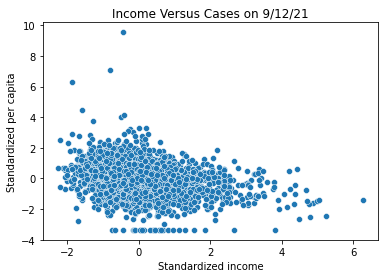

In [24]:
# merged_df['Standardized income'] = (merged_df['median_household_income'] - np.mean(merged_df['median_household_income'])) / (np.std(merged_df['median_household_income']))
# merged_df['Standardized per capita'] = (merged_df['Cases Per Capita'] - np.mean(merged_df['Cases Per Capita'])) / (np.std(merged_df['Cases Per Capita']))
# merged_df[['Standardized income', 'Standardized per capita']]
# sns.scatterplot(x=merged_df['Standardized income'], y=merged_df['Standardized per capita'])
# plt.title('Income Versus Cases on 9/12/21')
# cases_model = LinearRegression()
# cases_model.fit(np.array(merged_df['Standardized income']).reshape(-1, 1), merged_df['Standardized per capita']);
# cases_model.coef_

Here, we graph income in standard units vs the proportion of people who always or frequently use masks in standard units. We create a new column called 'Frequent Masks' which contains the proportion of people who always or frequently use masks. It is clear that there is a positive correlation between income and the proportion of people who always or frequently use masks. The theta value returned by the model is positive, meaning that there is a positive correlation. 

array([0.28548713])

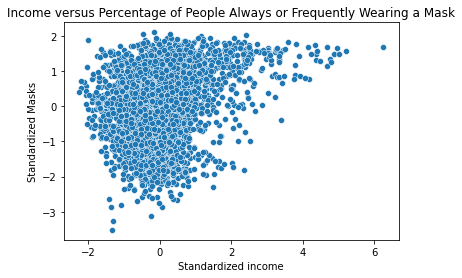

In [25]:
# merged_df['Frequent Masks'] = merged_df['FREQUENTLY'] + merged_df['ALWAYS']
# merged_df['Standardized Masks'] = (merged_df['Frequent Masks'] - np.mean(merged_df['Frequent Masks'])) / (np.std(merged_df['Frequent Masks']))
# merged_df[['Standardized income', 'Frequent Masks', 'Standardized Masks']]
# sns.scatterplot(x=merged_df['Standardized income'], y=merged_df['Standardized Masks']);
# plt.title('Income versus Percentage of People Always or Frequently Wearing a Mask')
# masks_model = LinearRegression()
# masks_model.fit(np.array(merged_df['Standardized income']).reshape(-1, 1), merged_df['Standardized Masks']);
# masks_model.coef_

Here, we create a baseline model for predicting whether or not a county is in the top 50% of counties in terms of income. This baseline model randomly predicts either a "0" or a "1", and we store these predictions in an array. We then compare these predictions to the actual values in the y_tst array, getting an accuracy of about 49%.

In [30]:
# np.random.seed(41)
# from sklearn.metrics import log_loss
# X_df = merged_df[['Standardized Masks', 'Standardized per capita']]
# top_50_percent = np.percentile(merged_df['Standardized income'], 50)
# high_income = merged_df['Standardized income'] > top_50_percent
# merged_df['High Income'] = high_income
# X_tr_base, X_tst_base, y_tr_base, y_tst_base = train_test_split(X_df, np.array(high_income), random_state=42, test_size=0.2)

# baseline_model_predictions = [np.random.randint(0, 2) for x in np.arange(len(y_tst_base))]
# baseline_accuracy = sum([baseline_model_predictions[x] == y_tst_base[x] for x in np.arange(len(y_tst_base))]) / len(y_tst_base) 
# print(f"A baseline model that randomly guesses either 0 or 1 has an accuracy of {baseline_accuracy}")
# print(f"The same baseline model has a cross-entropy loss (log loss) of {log_loss(y_tst_base, baseline_model_predictions)}")

A baseline model that randomly guesses either 0 or 1 has an accuracy of 0.48966613672496023
The same baseline model has a cross-entropy loss (log loss) of 17.626515670500606


Here, we are creating a new column called "High Income" which contains a boolean value for whether or not the county is in the top 50% of counties in terms of median household income. We then train a logistic regression model that uses the proportion of people who always or frequently use masks and the amount of COVID cases per capita on 9/12/21. The model achieves an accuracy of around 62% on the test data. While this is not particularly good, it is significantly better than a random classifier which would be expected to have an accuracy of around 50%. Using binomial CDF with 629 trials (number of test points) and probability of success 50% (for a random classifier), the chance of getting 390 or more correct classifications (62% accuracy) is less than 0.000001, showing that the proportion of people who always or frequently wear masks and cases per capita are correlated with income.

In [31]:
# from sklearn.linear_model import LogisticRegression

In [32]:
# X_df = merged_df[['Standardized Masks', 'Standardized per capita']]
# high_income_classifier = LogisticRegression()
# X_tr, X_tst, y_tr, y_tst = train_test_split(X_df, np.array(high_income), random_state=42, test_size=0.2)
# high_income_classifier.fit(X_tr, y_tr)
# print(f"Accuracy of logistic regression classifier is {high_income_classifier.score(X_tst, y_tst)}")
# print(f"Cross entropy loss of logistic regression classifier is {log_loss(y_tst, high_income_classifier.predict(X_tst))}")

Accuracy of logistic regression classifier is 0.6200317965023847
Cross entropy loss of logistic regression classifier is 13.123769024668352


In the following cell, we will do 5-fold cross validation of the Logistic Regression model that we created above. The accuracy ranges between 0.59 and 0.63 when we do cross validation.

In [33]:
# from sklearn.model_selection import cross_val_score

In [34]:
# logistic_regression = LogisticRegression()
# scores = cross_val_score(logistic_regression, X_tr, y_tr, cv=5)
# print(f"When doing 5-fold cross validation for our logistic regression model, our 5 accuracies are:  {scores[0]}, {scores[1]}, {scores[2]}, {scores[3]}, {scores[4]}.")

When doing 5-fold cross validation for our logistic regression model, our 5 accuracies are:  0.6163021868787276, 0.6003976143141153, 0.6095617529880478, 0.5956175298804781, 0.6254980079681275.


The following method classifies a prediction as either a true positive, false positive, false negative, or true negative and calculates the precision and recall. The cell after this one graphs the test set and shows which points are true positives, false positives, false negatives, or true negatives. The cell after that does the same thing but with the baseline model.

In [35]:
# def scorer(predicted, actual):
#     prediction_type = []
#     TP = 0
#     FP = 0
#     FN = 0
#     TN = 0
#     for i in range(len(predicted)):
#         if predicted[i] == True and actual[i] == True:
#             prediction_type.append('TP')
#             TP += 1
#         elif predicted[i] == True and actual[i] == False:
#             prediction_type.append('FP')
#             FP += 1
#         elif predicted[i] == False and actual[i] == True:
#             prediction_type.append('FN')
#             FN += 1
#         elif predicted[i] == False and actual[i] == False:
#             prediction_type.append('TN')
#             TN += 1
#     precision = TP / (TP + FP)
#     recall = TP / (TP + FN)
#     print('Precision = ', precision)
#     print('Recall = ', recall)
#     return prediction_type

Precision =  0.6413793103448275
Recall =  0.5794392523364486


Text(0.5, 1.0, 'Each Data Entry in the Testing Array Classified by Improved Model')

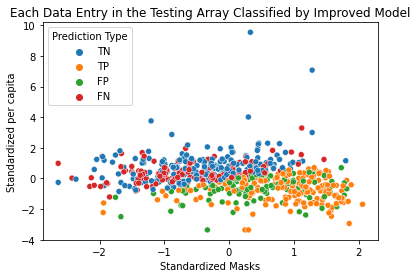

In [36]:
# predictions = high_income_classifier.predict(X_tst)
# X_tst['Prediction Type'] = scorer(predictions, y_tst)
# sns.scatterplot(data=X_tst, x='Standardized Masks', y='Standardized per capita', hue='Prediction Type');
# plt.title('Each Data Entry in the Testing Array Classified by Improved Model')

Precision =  0.5
Recall =  0.5109034267912772


Text(0.5, 1.0, 'Each Data Entry in the Testing Array Classified by Baseline Model')

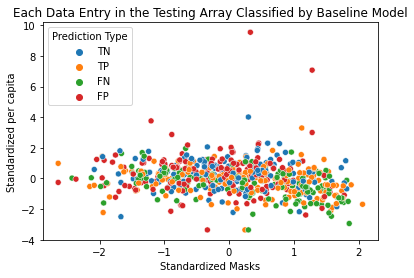

In [37]:
# X_tst_base['Prediction Type'] = scorer(baseline_model_predictions, y_tst_base)
# sns.scatterplot(data=X_tst_base, x='Standardized Masks', y='Standardized per capita', hue='Prediction Type');
# plt.title('Each Data Entry in the Testing Array Classified by Baseline Model')

Here, we use built-in sklearn methods to make a confusion matrix for the logisitic regression classifier, then visualize the four catagories of the confusion matrix in a heatmap. The next cell below does the same thing but with the baseline model

Text(0.5, 1.0, 'Heat Map of All TF, TP, FN, FP for Improved Model')

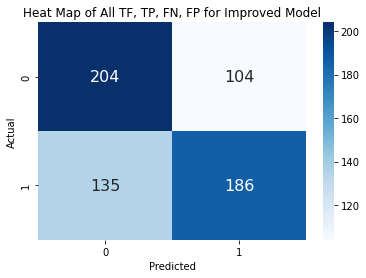

In [38]:
# from sklearn.metrics import confusion_matrix

# my_cm = confusion_matrix(y_tst, predictions)
# sns.heatmap(my_cm, annot = True, fmt = 'd', cmap = 'Blues', annot_kws = {'size': 16})
# plt.xlabel('Predicted')
# plt.ylabel('Actual')
# plt.title('Heat Map of All TF, TP, FN, FP for Improved Model')

Text(0.5, 1.0, 'Heat Map of All TF, TP, FN, FP for Baseline Model')

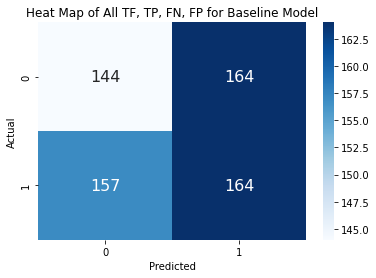

In [39]:
# base_cm = confusion_matrix(y_tst, baseline_model_predictions)
# sns.heatmap(base_cm, annot = True, fmt = 'd', cmap = 'Blues', annot_kws = {'size': 16})
# plt.xlabel('Predicted')
# plt.ylabel('Actual')
# plt.title('Heat Map of All TF, TP, FN, FP for Baseline Model')

Here, we using the bootstrap method to construct a 95% confidence interval for the coefficient, theta, for the Income vs Cases regression. The entire confidence interval is negative and does not contain 0, so we can conclude that income is negatively correlated with the number of COVID cases per capita on 9/12/21.

In [40]:
# bootstrap_copy = merged_df.copy()
# coeffs = []
# for i in range(1000):
#     sample_df = bootstrap_copy.sample(frac=1, replace=True)
#     X_values = sample_df[['Standardized per capita']]
#     y_values = sample_df['Standardized income']
#     X_tr, X_tst, y_tr, y_tst = train_test_split(X_values, y_values, random_state=42, test_size=0.2)
#     m = LinearRegression()
#     m.fit(X_tr, y_tr)
#     coeffs.append(m.coef_[0])

# print('95% confidence interval of theta for Income vs Cases regression:', (np.percentile(coeffs, 2.5), np.percentile(coeffs, 97.5)))

95% confidence interval of theta for Income vs Cases regression: (-0.34402795470655234, -0.25853670559188174)


In the following cell, we are using the bootstrap method to construct a 95% confidence interval for the coefficient, theta, for the Income vs Frequent + Always Mask Users Regression. The entire confidence interval is positive and does not contain 0, so we can conclude that income is positively correlated with the proportion of people who frequently or always wear a mask. 

In [41]:
# bootstrap_copy = merged_df.copy()
# coeffs = []
# for i in range(1000):
#     sample_df = bootstrap_copy.sample(frac=1, replace=True)
#     X_values = sample_df[['Standardized Masks']]
#     y_values = sample_df['Standardized income']
#     X_tr, X_tst, y_tr, y_tst = train_test_split(X_values, y_values, random_state=42, test_size=0.2)
#     m = LinearRegression()
#     m.fit(X_tr, y_tr)
#     coeffs.append(m.coef_[0])

# print('95% confidence interval of theta for Income vs Masks regression:', (np.percentile(coeffs, 2.5), np.percentile(coeffs, 97.5)))

95% confidence interval of theta for Income vs Masks regression: (0.24602790721400372, 0.325616361335495)


Here, we are using the bootstrap method to construct a 95% confidence interval for the 2 coefficients for the logistic regression model described earlier. The coefficient corresponding to mask usage has a confidence interval that is completely positive, showing that the frequency of people who frequently or always wear masks is positively correlated with whether or not a county is high income. The coefficient corresponding to cases per capita on 9/12/21 has a confidence interval that is completely negative, showing that the cases per capita on 9/12/21 is negatively correlated with whether or not a county is high income. 

In [42]:
# bootstrap_copy = merged_df.copy()
# coeff_1 = []
# coeff_2 = []
# for i in range(1000):
#     sample_df = bootstrap_copy.sample(frac=1, replace=True)
#     X_values = sample_df[['Standardized Masks', 'Standardized per capita']]
#     y_values = sample_df['High Income']
#     X_tr, X_tst, y_tr, y_tst = train_test_split(X_values, y_values, random_state=42, test_size=0.2)
#     m = LogisticRegression()
#     m.fit(X_tr, y_tr)
#     coeff_1.append(m.coef_[0][0])
#     coeff_2.append(m.coef_[0][1])

# print('95% confidence interval of theta 1 (mask usage) for logistic regression:', (np.percentile(coeff_1, 2.5), np.percentile(coeff_1, 97.5)))
# print('95% confidence interval of theta 2 (cases per capita) for logistic regression:', (np.percentile(coeff_2, 2.5), np.percentile(coeff_2, 97.5)))

95% confidence interval of theta 1 (mask usage) for logistic regression: (0.1825255281892261, 0.35989768455344134)
95% confidence interval of theta 2 (cases per capita) for logistic regression: (-0.5255675139367489, -0.3496968387615892)


Overall, based on the results of the previous three cells in which we use the bootstrap method, we can reject the null hypothesis that all coefficients are equal to zero.  We can conclude that the median household income in a county is positively correlated with the proportion of people in that county that frequently or always use a mask, and we can conclude that the the median household income in a county is negatively correlated with the COVID cases per capita in that county.

<!-- BEGIN QUESTION -->

### Question 6a

Train a baseline model where $f$ is the model described in Question 0a and $x$ is a quantity of *your* choice. Note that you may used *any* supervised learning approach we have studied; you are not limited to a linear model.

<!--
BEGIN QUESTION
name: q6a
points: 0
manual: True
-->

In [ ]:
...

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### Question 6b

Improve your model from part (a). Specify the supervised model you choose and write $f(x)$ as a function of the chosen features and parameters in your model. Justify why you chose these features and how you expect they will correlate with the output you wish to predict.

<!--
BEGIN QUESTION
name: q6b
points: 0
manual: True
-->

In [ ]:
...

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### Question 6c

If applicable, write an equation or rule for the prediction function $f(x)$; if this is infeasible, make sure to visualize your model parameters in some way. Interpret your improved model's optimal parameters (*hint*: refer to 1aiii), and compare these parameters to those of the baseline model. Comment on whether the parameters follow physical intuition given the nature of the prediction task.

For example, if you chose to use a decision tree, you may interpret the generated rules.
 
<!--
BEGIN QUESTION
name: q6c
points: 0
manual: True
-->

_Type your answer here, replacing this text._

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### Question 6d

Discuss your improved model's performance on both short-term and long-term time scales using a metric of your choice (*hint:* we're using an autoregressive model). In other words, given $x_t$, we wish to predict $\hat{x}_{t+k}$, and plot the error of these predictions for two $k$ values of your choice. You may use any reasonable interpretation of short-term and long-term predictions; an initial suggestion is to use 2-day predictions and 2-week predictions.

Compare the performance of this model on both timescales with the baseline model.

<!--
BEGIN QUESTION
name: q6d
points: 0
manual: True
-->

In [ ]:
...

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### Question 6e

Plot and describe the error for both the baseline and improved models as a function of time. In other words, given $x_t$, we wish to predict $\hat{x}_{t+k}$, and plot the error of these predictions for all $k$.

Consider how and why the performance of the model degrades as a function of time using the rate of growth in the error.

<!--
BEGIN QUESTION
name: q6e
points: 0
manual: True
-->

In [ ]:
...

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### Question 6f

Consider a modification to the model $f(x) = x_{t+1}$ where instead $f(x) = [x_{t+1}, x_{t+2}, ..., x_{t+m}]$ for some $m > 1$. In other words, using the features $x$ that contain past and present quantities, our model *explicitly* predicts values for $m$ days in the future rather than simply the next day (i.e. $m = 1$). 

Train the baseline and improved model using $m = 5$ and $m = 10$. Evaluate and visualize the predictive accuracy of both models.

<!--
BEGIN QUESTION
name: q6f
points: 0
manual: True
-->

In [ ]:
...

---

To double-check your work, the cell below will rerun all of the autograder tests.

In [47]:
grader.check_all()

q1a results: All test cases passed!

q1d results: All test cases passed!

q1e results: All test cases passed!

q5b results: All test cases passed!

q5d results: All test cases passed!

q5f results: All test cases passed!

q5g results: All test cases passed!

q5i results: All test cases passed!

## Submission

Make sure you have run all cells in your notebook in order before running the cell below, so that all images/graphs appear in the output. The cell below will generate a zip file for you to submit. **Please save before exporting!**

In [2]:
# Save your notebook first, then run this cell to export your submission.
grader.export()